In [31]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

In [32]:
years = 10

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

tickers = ['SPY', 'BND', 'GLD', 'QQQ', ]

In [33]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate, auto_adjust=False)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ
Date                                                     
2015-12-21  171.428085  60.779785  103.150002  103.420273
2015-12-22  172.983734  60.697372  102.610001  104.100121
2015-12-23  175.125854  60.704842  102.309998  104.873100
2015-12-24  174.836807  60.749973  103.050003  104.854469
2015-12-28  174.437271  60.749973  102.269997  104.798584
...                ...        ...         ...         ...
2025-12-11  689.169983  74.260002  393.239990  625.580017
2025-12-12  681.760010  74.029999  395.440002  613.619995
2025-12-15  680.729980  74.120003  395.799988  610.539978
2025-12-16  678.869995  74.260002  395.890015  611.750000
2025-12-17  671.400024  74.239998  399.290009  600.409973

[2513 rows x 4 columns]


In [34]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ
Date                                              
2015-12-22  0.009034 -0.001357 -0.005249  0.006552
2015-12-23  0.012307  0.000123 -0.002928  0.007398
2015-12-24 -0.001652  0.000743  0.007207 -0.000178
2015-12-28 -0.002288  0.000000 -0.007598 -0.000533
2015-12-29  0.010616 -0.003099 -0.000685  0.015607
...              ...       ...       ...       ...
2025-12-11  0.002324  0.000000  0.010712 -0.003240
2025-12-12 -0.010810 -0.003102  0.005579 -0.019303
2025-12-15 -0.001512  0.001215  0.000910 -0.005032
2025-12-16 -0.002736  0.001887  0.000227  0.001980
2025-12-17 -0.011065 -0.000269  0.008552 -0.018711

[2512 rows x 4 columns]


Function to calculate Portfolio expected return
(Assumption: Futture returns are based on past returns)

In [35]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

Function to calculate Portfolio Standard Deviation

In [36]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

Covariance Matrix for all securities

In [37]:
cov_matrix = log_returns.cov()
print(cov_matrix)

          SPY       BND       GLD       QQQ
SPY  0.000129  0.000005  0.000005  0.000150
BND  0.000005  0.000012  0.000011  0.000006
GLD  0.000005  0.000011  0.000086  0.000008
QQQ  0.000150  0.000006  0.000008  0.000199


Portfolio Expected Return and Standard Deviation

In [38]:
# Creating Equally weighted portfolio
portfolio_value = 100000
weights = np.array([1/len(tickers)] * len(tickers))

portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)


Create function to give random z-score based on normal distribution

In [39]:
def random_z_score():
    return np.random.normal(0,1)

Create function to calculate ScenarioGainLoss

In [41]:
days = 5
def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

Run 10000 simulations

In [42]:
simulations = 10000
scenarioReturn =[]

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [43]:
confidence_interval = 0.95
VaR = -np.percentile(scenarioReturn, 100*(1- confidence_interval))
print("Monte Carlo VaR:", VaR)

Monte Carlo VaR: 2372.486814817685


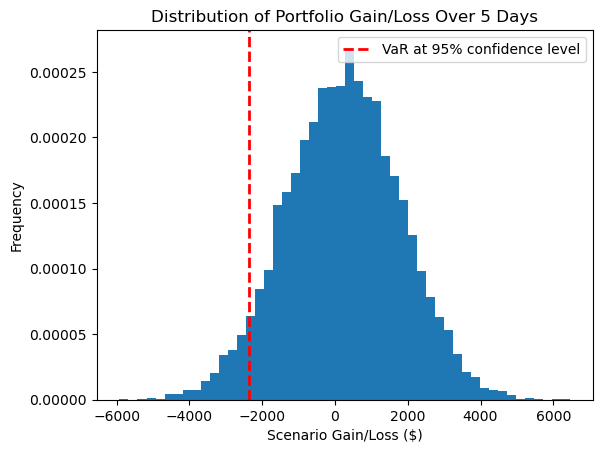

In [44]:
plt.hist(scenarioReturn, bins=50, density=True)
plt. xlabel('Scenario Gain/Loss ($)')
plt. ylabel ('Frequency')
plt. title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()

Monte Carlo Expected Shortfall

In [46]:
# Monte Carlo Expected Shortfall (ES)
losses = np.array(scenarioReturn)

# Identify VaR threshold
var_threshold = -VaR

# Losses beyond VaR
tail_losses = losses[losses <= var_threshold]

# Expected Shortfall
ES = -tail_losses.mean()

print("Monte Carlo Expected Shortfall:", ES)


Monte Carlo Expected Shortfall: 3042.825813559846


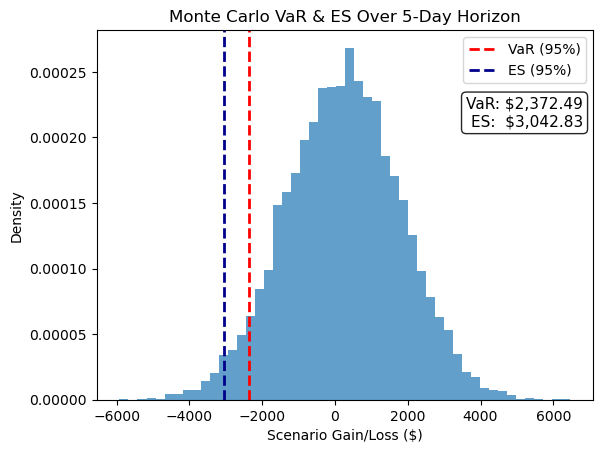

In [52]:
plt.hist(scenarioReturn, bins=50, density=True, alpha=0.7)

# VaR line
plt.axvline(
    -VaR,
    color='red',
    linestyle='dashed',
    linewidth=2,
    label=f'VaR ({confidence_interval:.0%})')

# ES line
plt.axvline(
    -ES,
    color='darkblue',
    linestyle='dashed',
    linewidth=2,
    label=f'ES ({confidence_interval:.0%})')

# Legend (top-right)
plt.legend(loc='upper right')

# ---- Numbers just below the legend ----
textstr = (
    f"VaR: ${VaR:,.2f}\n"
    f"ES:  ${ES:,.2f}")

plt.text(
    0.98, 0.82, textstr,              # slightly below legend
    transform=plt.gca().transAxes,
    fontsize=11,
    ha='right',
    va='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Density')
plt.title(f'Monte Carlo VaR & ES Over {days}-Day Horizon')
plt.show()

